# Fast AI

We are following the Fast.AI course available [here](https://course.fast.ai/).     

After the entire course, we will be able to :    
- Build an image classification model on pictures that you choose that will work at a world class level
- Classify text using whatever datasets you're interested in (identify movie review sentiment for instance)
- Make predictions of commercial applications like sales
- Build recommendation systems such as the one used by Netflix

Those can come top 10 in Kaggle competitions, and beat everything that's in the academic community.

![Deep Learning untrue](https://raw.githubusercontent.com/hiromis/notes/master/lesson1/5.png)



- It's not a black box. It's really great for interpreting what's going on.
- It does not need much data for most practical applications.
- You don't need a PhD. 
- It can be used very widely for lots of different applications, not just for vision.
- You don't need lots of hardware. 36 cents an hour server is more than enough to get world-class results for most problems.
- It is true that maybe this is not going to help you build a sentient brain, but that's not our focus. We are focused on solving interesting real-world problems.

### Les librairies utilisées en Deep Learning sont:
- Fast AI
- Pytorch
- Keras
- TensorFlow
- Theano (québécois)

Notons que Fast AI est une couche supérieure de Pytorch. Pytorch supplante Tensorflow, ce dernier étant plus ancien.

Keras s'appuie sur Tensorflow ou Theano, ou encore d'autre.


### What is FastAI library? http://docs.fast.ai/

Everything we are going to do is going to be using either FastAI or PyTorch which fastai sits on top of.     
**PyTorch** is fast growing extremely popular library. We use it because we used to use TensorFlow a couple years ago and we found we can do a lot more, a lot more quickly with PyTorch.

Currently fastai supports four applications:
- Computer vision
- Natural language text
- Tabular data
- Collaborative filtering

### The data we will be using:

Two main places that we will be tending to get data from for the course:

- **Academic datasets    **
Academic datasets are really important. They are really interesting. They are things where academics spend a lot of time curating and gathering a dataset so that they can show how well different kinds of approaches work with that data. The idea is they try to design datasets that are challenging in some way and require some kind of breakthrough to do them well.
We are going to start with an academic dataset called the pet dataset.
- **Kaggle competition datasets**

We are going to try to create models that get right up towards the top of Kaggle competitions, preferably in the top 10

# Lesson 1 - What's your pet

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

We import all the necessary packages.    
We are going to work with the <u>fastai V1</u> library which sits on top of <u>Pytorch 1.0</u>.    
**The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.**

*Note that the things starting by % are special directives to Jupyter Notebook itself, they are not Python code. They are called "magics." = if it is asked to plot something, then plot it here in this Notebook*

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

%matplotlib inline

### The data:

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the untar_data function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [0]:
# This is a dataset that fastai provides by itself:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [0]:
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
# We could have written the cell above like this:
# path = untar_data(URLs.PETS); path

In [0]:
# Method to know what composes 'path'
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

So we found that annotations and images are the directories in the PETS dataset.

Approach of using a **slash** like following:     
This is a really convenient function that's part of Python 3. It's functionality from **pathlib**.    
**Path object** is much better to use than strings. They let you use basically create sub paths like this.

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
print(path_anno) 
print(path_img)

/root/.fastai/data/oxford-iiit-pet/annotations
/root/.fastai/data/oxford-iiit-pet/images


### get_image_files:
FastAI method.  
It will just grab an array of all of the image files based on extension in a path.

In [0]:
fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

7390


[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_40.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_89.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/boxer_89.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pug_188.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_173.jpg')]

path/label.extension     

This is a pretty common way for computer vision datasets to get passed around - just one folder with a whole bunch of files in it. 

### ImageDataBunch:
FatsAI factory method.    
**An ImageDataBunch** is an object that represents all of the data you need to build a model and there's some factory method which try to make it really easy for you to create that data bunch: a <u>training set</u>, a <u>validation set</u> with images and labels.

In this case, we need to extract the labels from the names. We are going to use **from_name_re**. **re** is the module in Python that does regular expressions, really useful for extracting text.

In [0]:
# Here is the regex that extract the label for this dataset:
patt = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, patt, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,Abyssinian,boxer,staffordshire_bull_terrier,shiba_inu
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
german_shorthaired,yorkshire_terrier,Persian,pomeranian,english_cocker_spaniel
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

- path_img: a path containing images
- fnames: a list of file names
- pat: a regular expression (i.e. pattern) to be used to extract the label from the file name
- ds_tfm: we'll talk about transforms later
- size: what size images do you want to work with.

Images have size.      
This is a shortcoming of current deep learning technology which is that a GPU has to apply the exact same instruction to a whole bunch of things at the same time in order to be fast. If the images are different shapes and sizes, you can't do that. So we actually have to **make all of the images the same shape and size**. In part 1 of the course, we are always going to be making images square shapes. Part 2, we will learn how to use rectangles as well. It turns out to be surprisingly nuanced. But pretty much everybody in pretty much all computer vision modeling nearly all of it uses this approach of square. **224 by 224**, for reasons we'll learn about, is an extremely common size that most models tend to use so if you just use **size=224**, you're probably going to get pretty good results most of the time.

**ImageDataBunch.from_name_re is going to return a DataBunch object.     
In fastai, everything you model with is going to be a DataBunch object.**    
Basically **DataBunch object** contains 2 or 3 datasets: it contains your <u>training data</u>, <u>validation data</u>, and <u>optionally test data</u>.     
For each of those, it contains <u>your images and your labels</u>, <u>your texts and your labels</u>, or <u>your tabular data and your labels</u>, or so forth. And that all sits there in this one place.

If your data is not normalized, it can be quite difficult for your model to train well. So if you have trouble training a model, firt check if you've normalized it.

### data.show_batch:    

Let's take a look at a few pictures. Here are a few pictures of things from my data bunch. So you can see data.show_batch can be used to show me some of the contents in my data bunch. So you can see roughly what's happened is that they all seem to have being zoomed and cropped in a reasonably nice way. So basically what it'll do is something called by default **center cropping** which means it'll grab the middle bit and it'll also resize it. We'll talk more about the detail of this because it turns out to actually be quite important, but basically a <u>combination of cropping and resizing</u> is used.

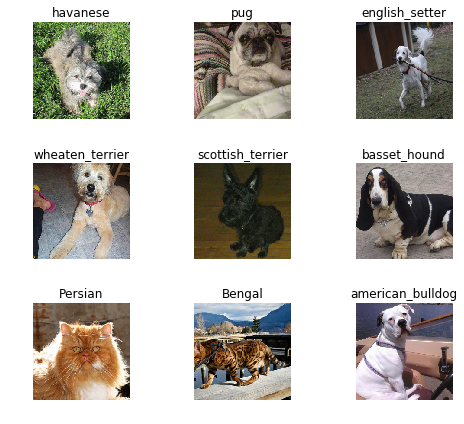

In [0]:
data.show_batch(rows=3, figsize=(7,6))

After seeing some pictures, we'll also take a look at the **labels**.    
All of the possible label names are called **classes**.     
With DataBunch, you can print out the classes:

In [0]:
print(data.classes)
len(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


37

That's all of the possible labels that we found by using that regular expression on the file names.

In [0]:
data.c # = property that gives the number of classes
# This element is really important, especially for multi-label classification problems, but also for regression problems.

37

### Training with ResNet34:

We can already train our model!

In Fast Ai, a model is trained using something called a **"learner"**.

- **DataBunch:** A general fastai concept for your data, and from there, there are subclasses for particular applications like ImageDataBunch
- **Learner:** A general concept for things that can learn to fit a model. From that, there are various subclasses to make things easier in particular, there is a **convnet learner** that will create a convolutional neural network for you.

For now, just know that **to create a learner** for a convolutional neural network, you just have to tell it two things: 
- data: what's your data. Not surprisingly, it takes a data bunch. 
- arch: what's your architecture (model). There are lots of different ways of constructing a convolutional neural network.
- + metrics : metrics are literally just things that gets printed out as it's training. Here I would like to print out error rate.

For now, the most important thing to know is that there's a particular kind of model called **ResNet** which works extremely well nearly all the time. For a while you really only need to be doing choosing between two things which is what size ResNet do you want: there are <u>ResNet34</u> and <u>ResNet50</u>. When we are getting started with something, the best is to pick a smaller one because it'll train faster. That's as much as you need to know to be a pretty good practitioner about architecture for now. Start with a smaller one and see if it's good enough.

That is all the information we need to create a convolutional neural network learner.

So we will start training our model using a cnn: a **convolutional neural network** backbone and a fully connected head with a single hidden layer as a classifier.    
For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

In [0]:
doc(cnn_learner)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 27765993.05it/s]


The first time we run this on a newly installed box, **it downloads the ResNet34 pre-trained weights**. What that means is that this particular model has actually already been trained for a particular task. And that particular task is that <u>it was trained on looking at about one and a half million pictures of all kinds of different things, a thousand categories of things, using an image dataset called **ImageNet**</u>. So we can download those pre-trained weights so that we don't start with a model that knows nothing about anything, but we actually start with a model that knows how to recognize a thousand categories of things in ImageNet. I don't think all of these 37 categories of pet are in ImageNet but there were certainly some kinds of dog and some kinds of cat. So this pre-trained model knows quite a little bit about what pets look like, and it certainly knows quite a lot about what animals look like and what photos look like. So the idea is that we don't start with a model that knows nothing at all, but **we start by downloading a model that knows something about recognizing images already**. So it downloads for us automatically, the first time we use it, a pre-trained model and then from now on, it won't need to download it again.

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### Fitting our model to our data:

Nowadays, the best way to fit deep learning models is with **fit_one_cycle** (since march 2018).

We will train for 4 epochs (4 cycles through all our data).

For now, just know that this number, 4, basically decides how many times do we go through the entire dataset, how many times do we show the dataset to the model so that it can learn from it. Each time it sees a picture, it's going to get a little bit better. But it's going to take time and it means it could overfit. If it sees the same picture too many times, it will just learn to recognize that picture, not pets in general. We'll learn all about how to tune this number during the next couple of lessons but starting out with 4 is a pretty good start just to see how it goes and you can actually see after four epochs or four cycles, we got an error rate of 6%. And it took only 6 minutes.

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.396691,0.340454,0.106225,01:27
1,0.553785,0.252930,0.085927,01:29
2,0.345136,0.202206,0.066982,01:30
3,0.254576,0.196100,0.066982,01:30


So 93% of the time, we correctly picked the exact right one of those 37 dog and cat breeds which feels pretty good to me. But to get a sense of how good it is, maybe we should go back and look at the paper. Remember, I said the nice thing about using academic papers or Kaggle dataset is we can compare our solution to whatever the best people in Kaggle did or in the academics did. The models as you'll read about in the [paper](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf), it's really pet specific. They learn something about how pet heads look and how pet bodies look, and pet image in general look. And they combine them all together and once they use all of this complex code and math, they got an accuracy of 59%. So in 2012, this highly pet specific analysis got an accuracy of 59%. These were the top researchers from Oxford University. Today in 2018, with basically about three lines of code, we got 94% (i.e. 6% error). So that gives you a sense of how far we've come with deep learning, and particularly with PyTorch and fastai, how easy things are.

We've got this trained model and what's actually happened as we'll learn is it's basically creating a set of **weights**. If you've ever done anything like a linear regression or logistic regression, you'll be familiar with coefficients. We basically found some **coefficients** and **parameters** that work pretty well.    
So if we want to start doing some more playing around and come back later, we probably should save those weights. You can just go **learn.save** and give it a name. It's going to put it in a model subdirectory in the same place the data came from, so if you save different models or different data bunches from different datasets, they'll all be kept separate. 

In [0]:
learn.save('Cats_Dogs-stage-1')

There's only one major other piece of software like fastai that tries to make deep learning easy to use and that's **Keras**.    
Keras is a really terrific piece of software. It runs on top of **Tensorflow**. It was the gold standard for making deep learning easy to use before, but life is much easier with fastai. So if you look at the last year's course exercise which is getting dogs vs. cats, fastai lets you get much more accurate (less than half the error on a validation set), training time is less than half the time, lines of code is about 1/6. The lines of code are more important than you might realize because those 31 lines of Keras code involved you making a lot of decisions, setting lots of parameters, doing lots of configuration. So that's all stuff where you have to know how to set those things to get best practice results. Or else, those 5 lines of code with fastai, any time we know what to do for you, we do it for you. Anytime we can pick a good default, we pick it for you. So hopefully you will find this a really useful library, not just for learning deep learning but for taking it a very long way.

![comparison](https://raw.githubusercontent.com/hiromis/notes/master/lesson1/105.png)

### Results:


To see what comes out, we can use a **classification interpretation object** that we'll call 'interp'. We are going to use this factory method from learner, so we pass in a learn object. Remember a learn object knows two things:
- What's your data
- What is your model. Now it's not just an architecture, it's actually a trained model.    

That's all the information we need to interpret that model.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

One of the things, perhaps the most useful things to do is called **plot_top_losses**.     
We are going to be learning a lot about this idea of **loss functions** shortly but in short, a loss function is something that tells you how good was your prediction. Specifically that means if you predicted one class of cat with great confidence, but actually you were wrong, then that's going to have a high loss because you were very confident about the wrong answer. So that's what it basically means to have high loss. By plotting the top losses, we are going to find out what were the things that we were the most wrong on, or the most confident about what we got wrong.

In [0]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

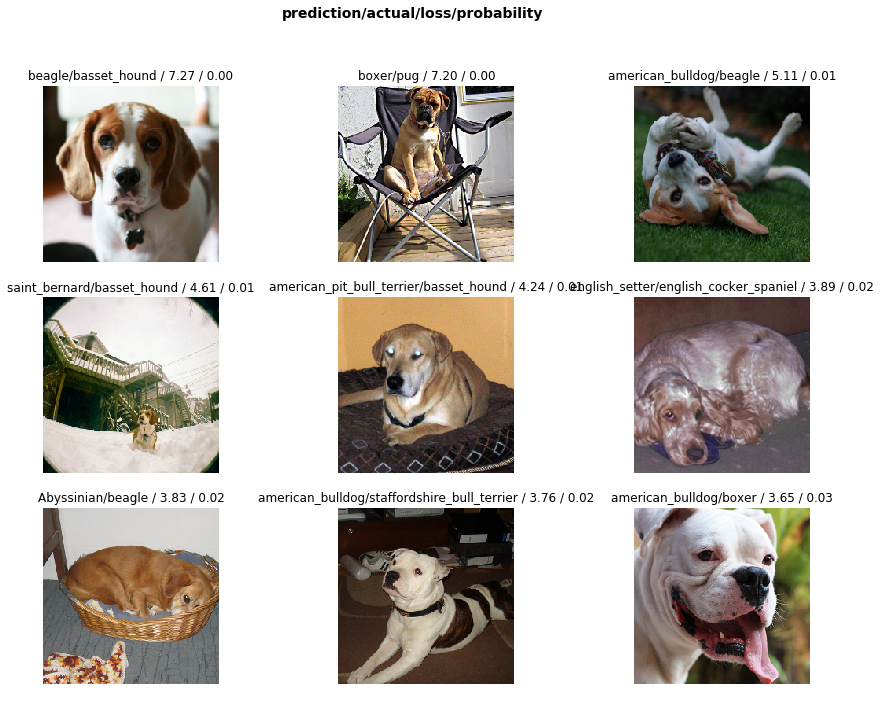

In [0]:

interp.plot_top_losses(9, figsize=(15,11))

In [0]:
# If you want to know more about a method just type the following for instance, with the doc() method.
# Then, click on "Show in docs"
# Then gain, in the fastai documentation, you can click on "source" to see the source code behind the method.
doc(interp.plot_top_losses)

First we just saw which were the categories that the model most confused with one another. We try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Prediction / Actual class / % Loss / % Probability of actual class    
.

Furthermore, when we plot the **confusion matrix below**, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

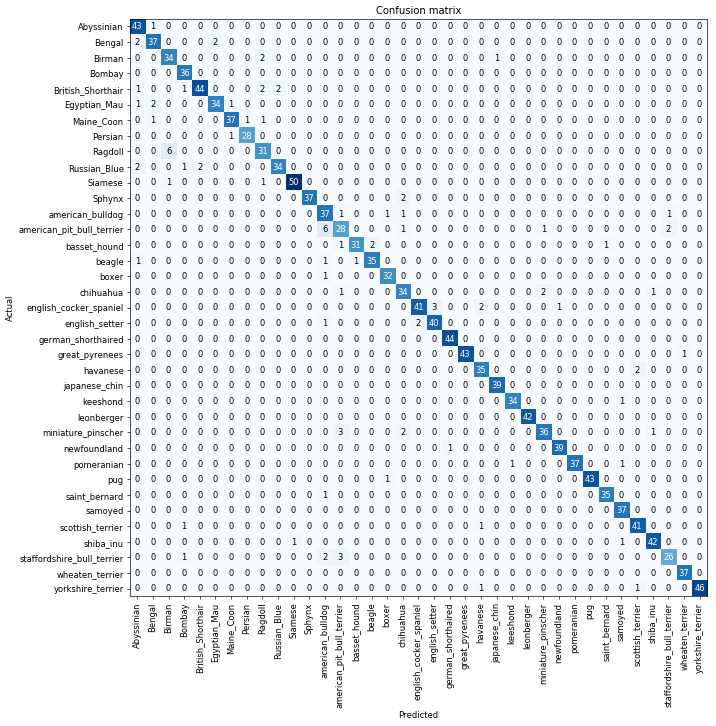

In [0]:
interp.plot_confusion_matrix(figsize=(15,12), dpi=60)

You can see there is slightly darker ones like a five somewhere, but it's really hard to read exactly what their combination is. So what I suggest instead of, if you've got lots of classes, don't use confusion matrix, but this is my favorite named function in fastai: you can call **most confused**.

In [0]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'american_bulldog', 6),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('basset_hound', 'beagle', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'havanese', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('havanese', 'scottish_terrier', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

**most_confused** will simply grab out of the confusion matrix the particular combinations of predicted and actual that <u>got wrong the most often</u>. 

- Actual
- Predicted
- Number of time this particular combination happened

So this is a very useful thing because you can look and say "with my domain expertise, does it make sense?"

### Unfreezing, fine-tuning, and learning rates:

Let's make our model better. How? We can make it better by using **fine-tuning**. So far we fitted 4 epochs and it ran pretty quickly. The reason it ran pretty quickly is that these convolutional networks have many layers. We'll learn a lot about exactly what layers are, but for now, just know it goes through a lot of computations. What we did was we added a few extra layers to the end and we only trained those. We basically left most of the model exactly as it was, so that's really fast. If we are trying to build a model at something that's similar to the original pre-trained model (in this case, similar to the ImageNet data), that works pretty well.

But what we really want to do is to go back and train the whole model. This is why we pretty much always use this two stage process. By default, when we call fit or fit_one_cycle on a cnn_learner, it'll just fine-tune these few extra layers added to the end and it will run very fast. It will basically never overfit but to really get it good, you have to call unfreeze. 

**unfreeze** is the thing that says please <u>train the whole model</u>. Then I can call fit_one_cycle again.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.614536,0.891741,0.236806,01:30
1,0.361739,0.243268,0.079838,01:29


The error got much worse. Why?

When we first trained the pre-trained model, we kept all of the layers pre-defined and pre-trained and we just trained a few more layers on top of all of those sophisticated features that are already being created.    
Now we are going back saying "let's change all of these". We will start with where they are.

First it seems very unlikely that we can make layer 1 features better. It's very unlikely that the definition of a diagonal line is going to be different when we look at dog and cat breeds versus the ImageNet data that this was originally trained on. So we don't really want to change the layer 1 very much if at all. Or else, the last layers, like types of dog face seems very likely that we do want to change that. So you want this intuition, this understanding that the different layers of a neural network represents different level of semantic complexity.

This is why our attempt to fine-tune this model didn't work because by default, it trains all the layers at the same speed which is to say it will update those things representing diagonal lines and gradients just as much as it tries to update the things that represent the exact specifics of what an eyeball looks like, so we have to change that.

To change it, we first of all need to go back to where we were before. We just broke this model, much worse than it started out. So if we just go: **learn.load('saved_model')**, this brings back the model that we saved earlier. So let's load that back up and now our models back to where it was before we killed it.

In [0]:
learn.load('Cats_Dogs-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,Abyssinian,boxer,staffordshire_bull_terrier,shiba_inu
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
german_shorthaired,yorkshire_terrier,Persian,pomeranian,english_cocker_spaniel
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64

So now, let's run **learning rate finder**. We'll learn about what that later, but for now, just know this is the thing that <u>figures out what is the fastest I can train this neural network</u> without making it zip off the rails and get blown apart.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


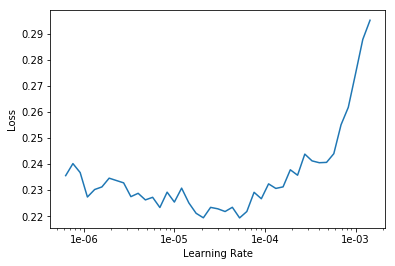

In [0]:
learn.recorder.plot()

This plots the result of our LR finder and what this basically shows you is this key parameter called a **learning rate**.    
**The learning rate** basically says how quickly am I updating the parameters in my model. The x-axis one here shows me what happens as I increase the learning rate. The y axis show what the loss is. So you can see, once the learning rate gets passed 10^-3, my loss gets worse. 

Because we are trying to fine-tune things now, we can't use such a high learning rate. So based on the learning rate finder, we try to pick something well before it started getting worse and put it as parameters in the fit_one_cycle(). So I decided to pick 1e-6. But there's no point training all the layers at that rate, because we know that the later layers worked just fine before when we were training much more quickly. So what we can actually do is we can <u>pass a range of learning rates to learn.fit_one_cycle</u>. And we do it like this:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))     # slice is a python value that permits to make a range with the start value and the stop value)

epoch,train_loss,valid_loss,error_rate,time
0,0.220466,0.189610,0.065629,01:29
1,0.208032,0.188311,0.061570,01:30


You use this keyword in Python called **slice** and that can take a start value and a stop value and basically what this says is train the very first layers at a learning rate of 1e-6, and the very last layers at a rate of 1e-4, and distribute all the other layers across that (i.e. between those two values equally).

We can see that we have here a pretty accurate model! Better than our first one, with an accuracy of 94% since the very first cycle. So when you use unfreeze, make sure to pik the rights learning rates for your model.

### Training with ResNet50:

We can improve our model by using more layers and basically we'll be doing it with a **ResNet50** instead of ResNet34. You'll see it's exactly the same as before, but I'm using ResNet50.

It's very likely that if you try to run this :     
<font color="blue">data2 = ImageDataBunch.from_name_re(path_img, fnames, patt, ds_tfms=get_transforms(),</font> <font color="red">size=229, bs=48</font><font color="blue">)</font>,     
you'll get an out of memory error and that's because it's just trying to do too much - too many parameter updates for the amount of RAM you have.    
If yours have less than 8G of GPU memory, you will get an error and the error will be your GPU has ran out of memory. The reason for that is that ResNet50 is bigger than ResNet34 (resnet34 is a 34 layer residual network while resnet50 has 50 layers), and therefore, it has more parameters and use more of your graphics card memory, just totally separate to your normal computer RAM, this is GPU RAM.

That's easily fixed. ImageDataBunch constructor has a parameter at the end : **bs**, a batch size. This basically says how many images do you train at one time. If you run out of memory, just make it smaller. Really it's fine to use a smaller batch size. It might take a little bit longer, that's all. 

In [0]:
# The data:
data2 = ImageDataBunch.from_name_re(path_img, fnames, patt, ds_tfms=get_transforms(), size=229, bs=32).normalize(imagenet_stats)

In [0]:
# Create the cnn model:
learn2 = cnn_learner(data2, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


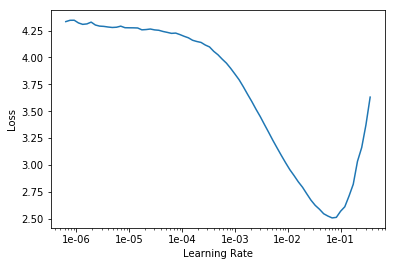

In [0]:
# Find the right learning rates:
learn2.lr_find()
learn2.recorder.plot()

In [0]:
# Fit the model with the best range of learning right as argument:
learn2.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.133703,0.969286,0.161028,01:41
1,0.908894,0.450973,0.090663,01:40
2,0.732235,0.414231,0.081191,01:38


In [0]:
# Save the model:
learn2.save('Cats_Dogs-stage-1-50')

In [0]:
# Test fit the model with the an other range of learning right as argument:
learn2.fit_one_cycle(3, max_lr=slice(1e-2,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,6.769833,12.685407,0.903248,01:39
1,4.355730,5.476997,0.675913,01:38
2,1.959222,1.770426,0.455345,01:38


This range of learning rate wasn't good. Let's get back to the model we saved just before:

In [0]:
learn2.load('Cats_Dogs-stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229)
y: CategoryList
saint_bernard,Abyssinian,boxer,pug,staffordshire_bull_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229)
y: CategoryList
great_pyrenees,miniature_pinscher,newfoundland,Russian_Blue,Persian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1,

In [0]:
# Interpret the results:
interp2 = ClassificationInterpretation.from_learner(learn2)

In [0]:
interp2.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Russian_Blue', 'British_Shorthair', 6),
 ('Ragdoll', 'Persian', 5),
 ('Birman', 'Ragdoll', 4),
 ('Birman', 'Siamese', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Ragdoll', 'Birman', 3),
 ('american_bulldog', 'boxer', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('boxer', 'american_bulldog', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('Abyssinian', 'Sphynx', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Persian', 'Ragdoll', 2),
 ('Ragdoll', 'Siamese', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('basset_hound', 'beagle', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

In [0]:
losses,idxs = interp2.top_losses()

len(data2.valid_ds)==len(losses)==len(idxs)

True

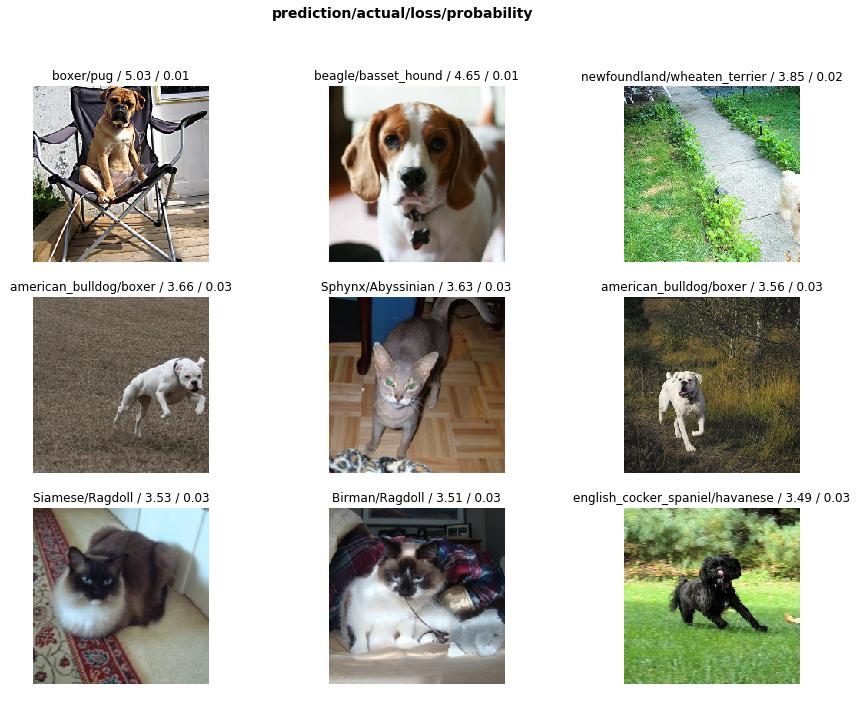

In [0]:
interp2.plot_top_losses(9, figsize=(15,11))

### Other data:

We'll see now how to **create labels in lots of different ways** because your dataset where you get it from won't necessarily be that kind of regex based approach. It could be in lots of different formats.     
So to show you how to do this, we'll use the <u>MNIST sample</u>. MNIST is a picture of hand drawn numbers.     
There are a lot of different ways of creating these datasets.

In [0]:
path = untar_data(URLs.MNIST_SAMPLE)
path

PosixPath('/root/.fastai/data/mnist_sample')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_sample/valid'),
 PosixPath('/root/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_sample/train')]

Here we can see that there are a training set and the validation set already. So basically the people that put together this dataset have already decided what they want you to use as a validation set.

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_sample/train/3'),
 PosixPath('/root/.fastai/data/mnist_sample/train/7')]

There are a folder called 3 and a folder called 7. This is really common way to give labels. Basically it says everything that's a 3, I put in a folder called 3. Everything that's a 7, I'll put in a folder called 7. This is often called an "ImageNet style dataset" because this is how ImageNet is distributed. So if you have something in this format where the labels are just whatever the folders are called, you can say **from_folder**.

**Creating labels with from_folder**

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

This created an ImageDataBunch for you and as you can see right after, it created the labels too:

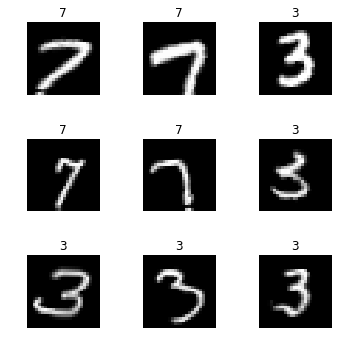

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
data

ImageDataBunch;

Train: LabelList (12396 items)
x: ImageList
Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_sample;

Valid: LabelList (2038 items)
x: ImageList
Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_sample;

Test: None

**Creating labels with from_csv**

We could come with a CSV file that would look something like this:

In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In this case, labels are not 3 or 7, they are 0 or 1 depending on if it's a 7 or not. So that's another possibility. If this is how your labels are, you can use **from_csv**:

In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [0]:
data

ImageDataBunch;

Train: LabelList (11548 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /root/.fastai/data/mnist_sample;

Valid: LabelList (2886 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,1,1,1,0
Path: /root/.fastai/data/mnist_sample;

Test: None

In [0]:
print(data.c)
data.classes

2


[0, 1]

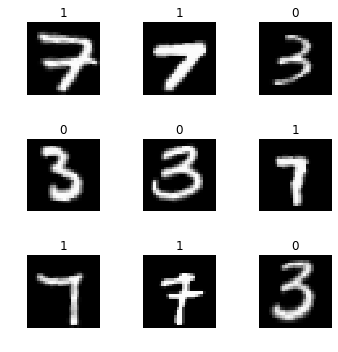

In [0]:
data.show_batch(rows=3, figsize=(5,5))

**Creating labels with from_name_re (regex):**

In [0]:
fn_paths = [path/name for name in df['name']] 
fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [0]:
# The pattern:
patt = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=patt, ds_tfms=tfms, size=24)
data.classes

['3', '7']

**Creating labels with from_name_func:**

This is a more complex way to create a Data Bunch. It is actually about creating an arbitrary function that extracts a label from the file name or path.

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

**Creating labels with from_lists:**

This is a more flexible way of creating a data bunch. It actually creates an array of labels.

In [62]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']

**Training the model with resnet18:**

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 26253456.40it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.159999,0.071126,0.975398,00:20
1,0.106707,0.041391,0.983714,00:19


In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('7', '3', 28), ('3', '7', 19)]

In [0]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

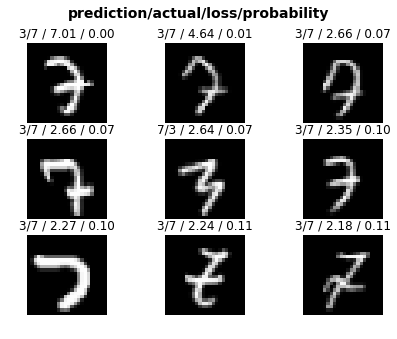

In [0]:
interp.plot_top_losses(9, figsize=(7,5))

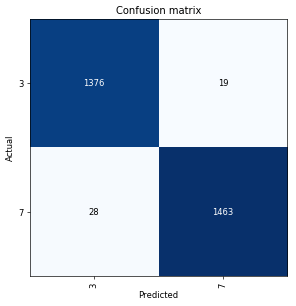

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)